# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
def resnet18(classes:int=10):
    return timm.create_model('resnet18', pretrained=False, in_chans=1, num_classes=classes).to(device)

In [6]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

In [7]:
# Предпочтительные параметры
size = 7.0E-6
near_N = 800 #2004 #1336
near_length = 5.6E-3
wavelength = 500.0E-9
detectors_amount = 24
masks_amount = 5
distance = 0.025

# Параметры обучения
batch_size = 20
learning_rate = 0.009854
loss_function_proportion = 0.609798
optimizer_type_name = 'Adam'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 20

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 
detector_size = length / 60

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер детекторов:                        {engineering(detector_size, 'м')}")
print(f"Количество детекторов:                    {detectors_amount} на {detectors_amount}")

print(f"Пропорция CE к MSE лосс:                  {loss_function_proportion}")
print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       800
Количество пикселей маски:                800
Размер оптических элементов:              5.6 мм
Размер пикселя маски:                     7.0 мкм
Расстояние между слоями:                  25.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    20
Размер детекторов:                        93.333 мкм
Количество детекторов:                    24 на 24
Пропорция CE к MSE лосс:                  0.609798
Размер батча:                             20
Тип оптимизатора:                         Adam


# Диапазон расстояний

In [8]:
# Настройка диапазона
distance_left_multiplier = 0.5
distance_right_multiplier = 1.0

slices = 20
distance_samples = 3
distance_array = numpy.linspace(distance*distance_left_multiplier, distance*distance_right_multiplier, distance_samples)

In [9]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - upper_integer(N*size/(length*2))
p1 = p0 + upper_integer(N*size/length)
if p1 <= p0: p1 = p0+1 
initial[0,0,p0:p1,p0:p1] = 1.0

with torch.no_grad():
    incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
    incoherent_encoder, incoherent_decoder = incoherent.pair()
    incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, dist in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, dist).to(device)
            result = incoherent_decoder.forward(propagation.forward(incoherent_encoder.forward(initial))).squeeze().abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.45s/it]


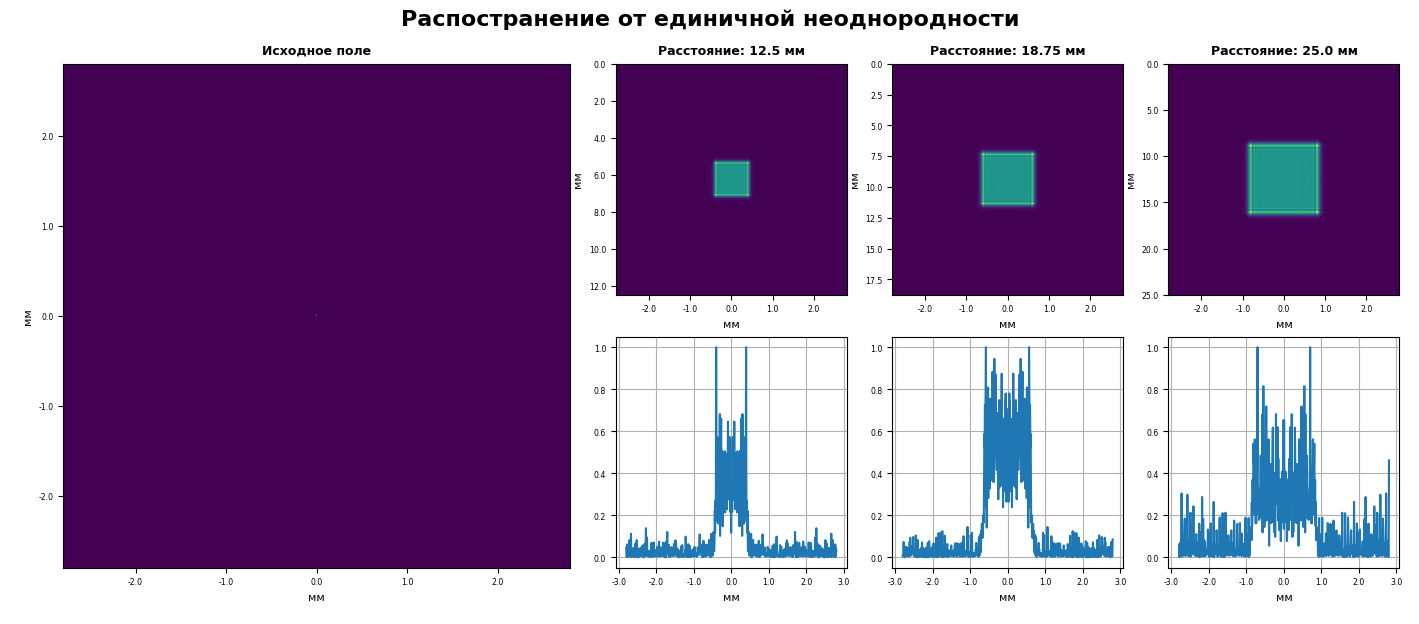

In [10]:
plot = TiledPlot(14, 14)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (dist, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(dist, 'м')
    plot.description.column.top(f"Расстояние: {engineering(dist,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.001), aspect='auto', extent=[-length/2,+length/2,dist,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

# Инициализация моделей

In [11]:
# Модуль некогерентности
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent_encoder, incoherent_decoder = incoherent.pair()
incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)

# Модули детекторов
spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors_incoherent = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)
detectors_coherent = deepcopy(detectors_incoherent)

# Электронные модели
electronic_incoherent = resnet18()
electronic_coherent = deepcopy(electronic_incoherent)

# Оптические модели
adjuster = AdjustSize(N, N)
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [phase_modulators[0], amplitude_modulators[0]]
for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
    elements.append(propagation)
    elements.append(phase_modulator)
    elements.append(amplitude_modulator)
elements.append(propagation)
optical_incoherent = CompositeModel(adjuster, incoherent_encoder, *deepcopy(elements), incoherent_decoder).to(device)
optical_coherent = CompositeModel(adjuster, *deepcopy(elements)).to(device)

# Гибридные модели
hybrid_model_incoherent = HybridModel(optical_incoherent, detectors_incoherent, electronic_incoherent).to(device)
hybrid_model_coherent = HybridModel(optical_coherent, detectors_coherent, electronic_coherent).to(device)

# Распределённые модели
model_incoherent = hybrid_model_incoherent
model_coherent = hybrid_model_coherent

# Набор данных
dataset = Dataset('CIFAR10', batch_size, None, None, torch.complex64, threads=1, preload=10)
dataset.load.train()
dataset.load.test()

# Тип оптимизатора и лосс-функция
loss_function = combined_loss(loss_function_proportion)
optimizer_type = optimizer_types_list[optimizer_type_name]

In [12]:
model_incoherent._optical_model._elements

(AdjustSize(),
 IncoherentEncoder(
   (_generator): GaussianNormalizer(
     (_generator): FourierMask()
   )
 ),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 IncoherentDecoder())

In [13]:
image, _ = next(iter(dataset.train))
image = image[0:2]
image = image.to(device)
print(image.shape)
image = model_incoherent._optical_model.forward(image)
print(image.shape)
image = model_incoherent._detectors.forward(image)
print(image.shape)
image = model_incoherent._electronic_model.forward(image)
print(image.shape)
torch.cuda.empty_cache()

torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 800, 800])
torch.Size([2, 1, 24, 24])
torch.Size([2, 10])


# Обучение модели

In [14]:
models_history, loss_histories, confusion_matrices_history = epochs(20, 10, model_incoherent, dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.0003)

Training main thread PID is: 291277
Training thread#0 PID is: 291478
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 291549
Training thread#2 PID is: 291750
Training thread#3 PID is: 291949
Training thread#4 PID is: 292148
Training thread#5 PID is: 292348
Training thread#6 PID is: 292547
Training thread#7 PID is: 292747
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.42it/s]
Accuracy in the beginning is 10.0
RLoss: 2.0228310237600677, RPI1000: -0.7545946348255165: 100%|█| 313/313 [04:58<
100%|█████████████████████████████████████████| 313/313 [02:08<00:00,  2.43it/s]
Accuracy after epoch 1 is 26.632
RLoss: 1.9579809971387974, RPI1000: -0.611183789864036:

In [15]:
models_history_, loss_histories_, confusion_matrices_history_ = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003)

Training main thread PID is: 348073
Training thread#0 PID is: 348275
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 348345
Training thread#2 PID is: 348544
Training thread#3 PID is: 348756
Training thread#4 PID is: 348955
Training thread#5 PID is: 349157
Training thread#6 PID is: 349356
Training thread#7 PID is: 349555
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.41it/s]
Accuracy in the beginning is 37.684
RLoss: 0.837595677067492, RPI1000: -1.5133715196277282: 100%|█| 313/313 [04:57<0
100%|█████████████████████████████████████████| 313/313 [02:08<00:00,  2.43it/s]
Accuracy after epoch 1 is 53.614
RLoss: 0.8394245850585003, RPI1000: -0.87060275184310

In [17]:
models_history__, loss_histories__, confusion_matrices_history__ = epochs(20, 10, models_history_[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.000003)

Training main thread PID is: 465404
Training thread#0 PID is: 465606
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 465676
Training thread#2 PID is: 465877
Training thread#3 PID is: 466076
Training thread#4 PID is: 466276
Training thread#5 PID is: 466485
Training thread#6 PID is: 466684
Training thread#7 PID is: 466886
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.41it/s]
Accuracy in the beginning is 56.674
RLoss: 0.3210676068005299, RPI1000: -0.9424036020429484: 100%|█| 313/313 [04:58<
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.42it/s]
Accuracy after epoch 1 is 59.006
RLoss: 0.3669620243252439, RPI1000: -0.44441081148847

In [18]:
models_history___, loss_histories___, confusion_matrices_history___ = epochs(40, 10, models_history__[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.0000003)

Training main thread PID is: 521948
Training thread#0 PID is: 522150
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 522220
Training thread#2 PID is: 522418
Training thread#3 PID is: 522619
Training thread#4 PID is: 522829
Training thread#5 PID is: 523028
Training thread#6 PID is: 523227
Training thread#7 PID is: 523427
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.41it/s]
Accuracy in the beginning is 59.984
RLoss: 0.2765144370048208, RPI1000: -0.38692246078093: 100%|█| 313/313 [04:57<00
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.42it/s]
Accuracy after epoch 1 is 60.146
RLoss: 0.2752699170801496, RPI1000: -0.32273466433341

In [ ]:
models_history____, loss_histories____, confusion_matrices_history____ = epochs(20, 10, models_history___[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00000003)

Training main thread PID is: 650367
Training thread#0 PID is: 650569
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 650640
Training thread#2 PID is: 650840
Training thread#3 PID is: 651039
Training thread#4 PID is: 651239
Training thread#5 PID is: 651439
Training thread#6 PID is: 651639
Training thread#7 PID is: 651839
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.41it/s]
Accuracy in the beginning is 60.442
RLoss: 0.25610698299584794, RPI1000: -0.1268612551376022: 100%|█| 313/313 [04:57
100%|█████████████████████████████████████████| 313/313 [02:09<00:00,  2.43it/s]
Accuracy after epoch 1 is 60.428
RLoss: 0.25532880205466557, RPI1000: -0.1252046924945

In [ ]:
# models_history, loss_histories, confusion_matrices_history = epochs(10, 10, model_incoherent, dataset, torch.nn.CrossEntropyLoss(), torch.optim.Adam, lr=0.0003)

In [ ]:
# models_history1, loss_histories1, confusion_matrices_history1 = epochs(10, 10, model_coherent, dataset, torch.nn.CrossEntropyLoss(), torch.optim.Adam, lr=0.0003)

In [ ]:
# models_history1, loss_histories1, confusion_matrices_history1 = epochs(30, 10, model_coherent, dataset, torch.nn.CrossEntropyLoss(), torch.optim.Adam, lr=0.0003)